In [1]:
from fastai.vision.all import *
from fastaudio.core.all import *
from fastaudio.augment.all import *
from fastaudio.ci import skip_if_ci

ModuleNotFoundError: No module named 'fastai'

In [ ]:
import torch
torch.cuda.is_available()

In [3]:
ep = "e01"

In [4]:
path = Path("data/audio/wav/segments")/ep

In [5]:
(path).ls()

(#281) [Path('data/audio/wav/segments/e01/seg_19.wav'),Path('data/audio/wav/segments/e01/seg_78.wav'),Path('data/audio/wav/segments/e01/seg_239.wav'),Path('data/audio/wav/segments/e01/seg_48.wav'),Path('data/audio/wav/segments/e01/seg_237.wav'),Path('data/audio/wav/segments/e01/seg_123.wav'),Path('data/audio/wav/segments/e01/seg_81.wav'),Path('data/audio/wav/segments/e01/seg_234.wav'),Path('data/audio/wav/segments/e01/seg_74.wav'),Path('data/audio/wav/segments/e01/seg_148.wav')...]

In [23]:
df = pd.read_json(path/"labels.json")
df["audio_path"] = path/df["segment_wav"]
df = df[df["actor"].notnull()]
df.head()

duration  end_time  episode_id   seg_type  start_time             tag  \
0      0.68     45.49           1  character       44.81    Gene Belcher   
1      2.48     48.05           1  character       45.57    Tina Belcher   
2      2.14     36.29           1  character       34.15     Bob Belcher   
3      1.68     37.97           1  character       36.29  Louise Belcher   
4      1.69     39.66           1  character       37.97    Gene Belcher   

  episode                     wav  segment_idx segment_wav       character  \
0     e01  data/audio/wav/e01.wav            0   seg_0.wav    Gene Belcher   
1     e01  data/audio/wav/e01.wav            1   seg_1.wav    Tina Belcher   
2     e01  data/audio/wav/e01.wav            2   seg_2.wav     Bob Belcher   
3     e01  data/audio/wav/e01.wav            3   seg_3.wav  Louise Belcher   
4     e01  data/audio/wav/e01.wav            4   seg_4.wav    Gene Belcher   

             actor                             audio_path  
0    Eugene Mirman  data/audio/wav/segments/e01/seg_0.wav  
1        Dan Mintz  data/audio/wav/segments/e01/seg_1.wav  
2  H. Jon Benjamin  data/audio/wav/segments/e01/seg_2.wav  
3   Kristen Schaal  data/audio/wav/segments/e01/seg_3.wav  
4    Eugene Mirman  data/audio/wav/segments/e01/seg_4.wav

In [24]:
# Helper function to split the data
def CrossValidationSplitter(col='fold', fold=1):
    "Split `items` (supposed to be a dataframe) by fold in `col`"
    def _inner(o):
        assert isinstance(o, pd.DataFrame), "ColSplitter only works when your items are a pandas DataFrame"
        col_values = o.iloc[:,col] if isinstance(col, int) else o[col]
        valid_idx = (col_values == fold).values.astype('bool')
        return IndexSplitter(mask2idxs(valid_idx))(o)
    return _inner

In [25]:
cfg = AudioConfig.BasicMelSpectrogram(n_fft=512)
a2s = AudioToSpec.from_cfg(cfg)

/home/skander/.cache/pypoetry/virtualenvs/ml-L4gBokpX-py3.9/lib/python3.9/site-packages/torchaudio/functional/functional.py:539: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (257) may be set too low.
  warnings.warn(


In [26]:
auds = DataBlock(blocks = (AudioBlock, MultiCategoryBlock),  
                 get_x = ColReader("audio_path"), 
                 splitter = RandomSplitter(seed=42),
                 batch_tfms = [a2s],
                 get_y = ColReader("actor"))

In [27]:
dbunch = auds.dataloaders(df, bs=64)

In [28]:
dbunch.show_batch(figsize=(10, 5))

RuntimeError: Error when trying to collate the data into batches with fa_collate, at least two tensors in the batch are not the same size.

Mismatch found on axis 0 of the batch and is of type `AudioTensor`:
	Item at index 0 has shape: torch.Size([1, 53280])
	Item at index 1 has shape: torch.Size([1, 36000])

Please include a transform in `after_item` that ensures all data of type AudioTensor is the same size

In [29]:
learn = cnn_learner(dbunch, 
            resnet18,
            n_in=1,  # <- This is the only audio specific modification here
            loss_func=CrossEntropyLossFlat(),
            metrics=[accuracy])

/home/skander/.cache/pypoetry/virtualenvs/ml-L4gBokpX-py3.9/lib/python3.9/site-packages/fastai/vision/learner.py:284: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/home/skander/.cache/pypoetry/virtualenvs/ml-L4gBokpX-py3.9/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/skander/.cache/pypoetry/virtualenvs/ml-L4gBokpX-py3.9/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn

In [30]:
@skip_if_ci
def run_learner():
    # epochs are a bit longer due to the chosen melspectrogram settings
    learn.fine_tune(10)

In [31]:
run_learner()

RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/skander/.cache/pypoetry/virtualenvs/ml-L4gBokpX-py3.9/lib/python3.9/site-packages/torch/utils/data/_utils/worker.py", line 302, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/skander/.cache/pypoetry/virtualenvs/ml-L4gBokpX-py3.9/lib/python3.9/site-packages/torch/utils/data/_utils/fetch.py", line 39, in fetch
    data = next(self.dataset_iter)
  File "/home/skander/.cache/pypoetry/virtualenvs/ml-L4gBokpX-py3.9/lib/python3.9/site-packages/fastai/data/load.py", line 140, in create_batches
    yield from map(self.do_batch, self.chunkify(res))
  File "/home/skander/.cache/pypoetry/virtualenvs/ml-L4gBokpX-py3.9/lib/python3.9/site-packages/fastai/data/load.py", line 170, in do_batch
    def do_batch(self, b): return self.retain(self.create_batch(self.before_batch(b)), b)
  File "/home/skander/.cache/pypoetry/virtualenvs/ml-L4gBokpX-py3.9/lib/python3.9/site-packages/fastai/data/load.py", line 168, in create_batch
    if not self.prebatched: collate_error(e,b)
  File "/home/skander/.cache/pypoetry/virtualenvs/ml-L4gBokpX-py3.9/lib/python3.9/site-packages/fastai/data/load.py", line 166, in create_batch
    try: return (fa_collate,fa_convert)[self.prebatched](b)
  File "/home/skander/.cache/pypoetry/virtualenvs/ml-L4gBokpX-py3.9/lib/python3.9/site-packages/fastai/data/load.py", line 52, in fa_collate
    else type(t[0])([fa_collate(s) for s in zip(*t)]) if isinstance(b, Sequence)
  File "/home/skander/.cache/pypoetry/virtualenvs/ml-L4gBokpX-py3.9/lib/python3.9/site-packages/fastai/data/load.py", line 52, in <listcomp>
    else type(t[0])([fa_collate(s) for s in zip(*t)]) if isinstance(b, Sequence)
  File "/home/skander/.cache/pypoetry/virtualenvs/ml-L4gBokpX-py3.9/lib/python3.9/site-packages/fastai/data/load.py", line 51, in fa_collate
    return (default_collate(t) if isinstance(b, _collate_types)
  File "/home/skander/.cache/pypoetry/virtualenvs/ml-L4gBokpX-py3.9/lib/python3.9/site-packages/torch/utils/data/_utils/collate.py", line 141, in default_collate
    return torch.stack(batch, 0, out=out)
  File "/home/skander/.cache/pypoetry/virtualenvs/ml-L4gBokpX-py3.9/lib/python3.9/site-packages/fastai/torch_core.py", line 376, in __torch_function__
    res = super().__torch_function__(func, types, args, ifnone(kwargs, {}))
  File "/home/skander/.cache/pypoetry/virtualenvs/ml-L4gBokpX-py3.9/lib/python3.9/site-packages/torch/_tensor.py", line 1121, in __torch_function__
    ret = func(*args, **kwargs)
RuntimeError: Error when trying to collate the data into batches with fa_collate, at least two tensors in the batch are not the same size.

Mismatch found on axis 0 of the batch and is of type `AudioTensor`:
	Item at index 0 has shape: torch.Size([1, 6080])
	Item at index 1 has shape: torch.Size([1, 10240])

Please include a transform in `after_item` that ensures all data of type AudioTensor is the same size


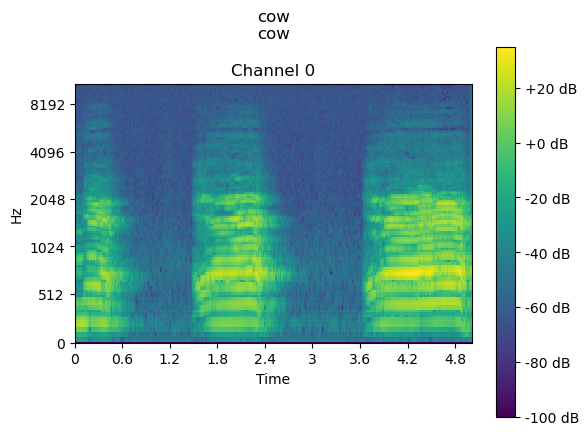

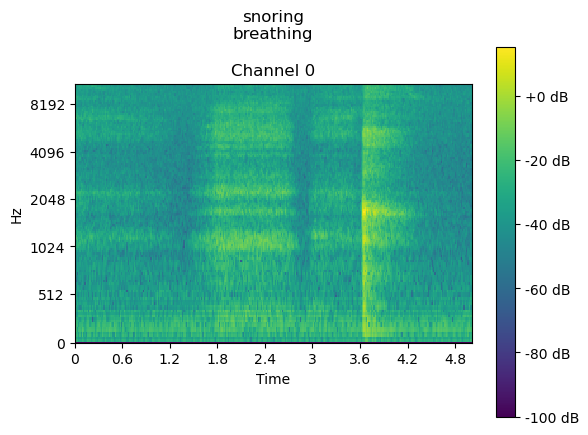

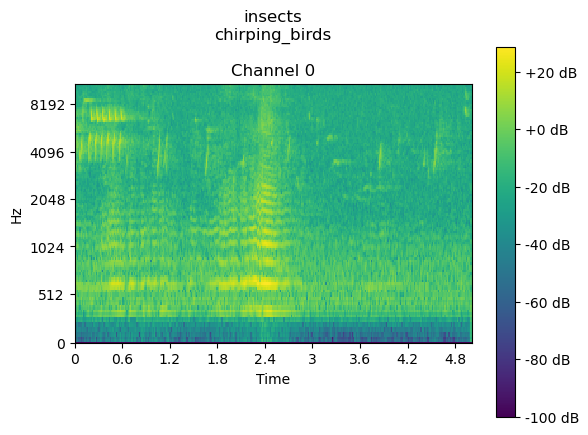

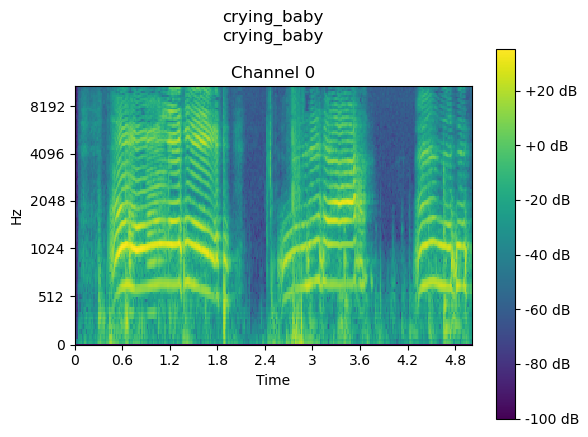

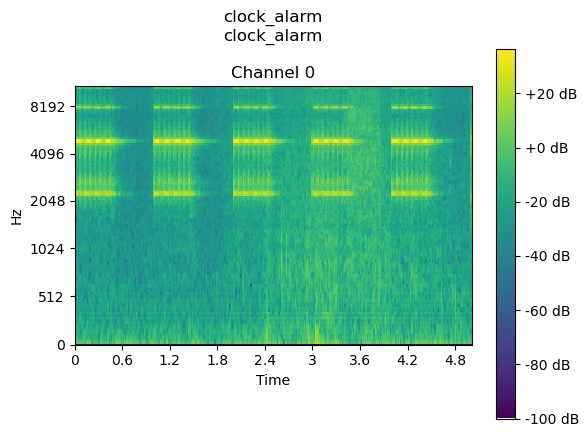

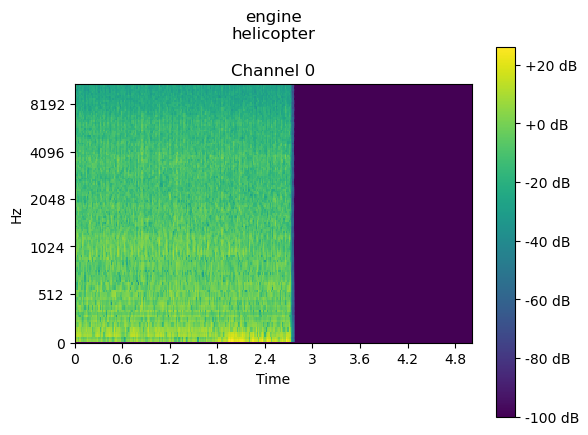

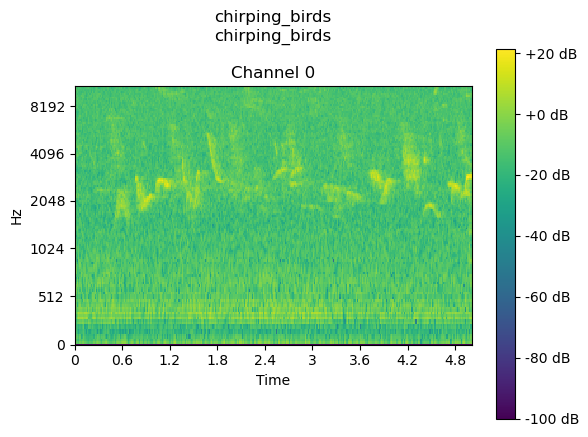

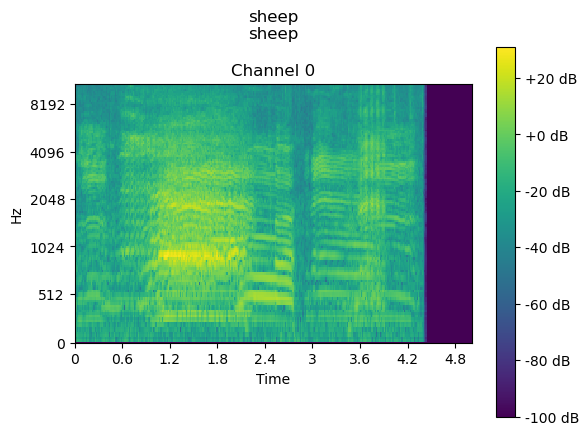

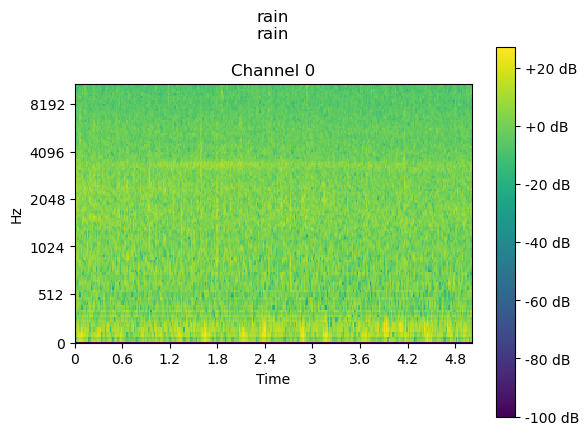

In [15]:
learn.show_results()